# Compute galaxy Pk from mock with Nenya

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bacco
import deepdish as dd
import pickle

/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
basedir = '/dipc_storage/cosmosims/MultiCosmology_N768/nenya_N768_output/0.00/'
halo_file = 'groups_000/fof_subhalo_history_tab_orph_wweight_000'
atarget = 1
sim = bacco.Simulation(basedir=basedir, halo_file=halo_file, closest_expfactor=atarget)
print(sim.Cosmology)

2024-02-04 18:30:35,406 bacco.sims : Initialising simulation Default
2024-02-04 18:30:35,407 bacco.sims : try /dipc_storage/cosmosims/MultiCosmology_N768/nenya_N768_output/0.00/groups_081/fof_subhalo_history_tab_orph_wweight_081
2024-02-04 18:30:35,411 bacco.sims : Loading /dipc_storage/cosmosims/MultiCosmology_N768/nenya_N768_output/0.00/groups_081/fof_subhalo_history_tab_orph_wweight_081
2024-02-04 18:30:35,424 bacco.cosmo :    initialization took 0.000 secs
2024-02-04 18:30:35,526 bacco.sims : ...done in 0.0221 s


-----------------------------------------------
Cosmology "Default", de_model "LCDM" 
- Paramerers: Omega_cdm = 0.265, Omega_b = 0.05, Omega_de = 0.685, 
Hubble=0.6, Sigma_8=0.9, A_s=None, ns=1.01, neutrino_mass=0.0, 
Omega_r=0.0, Omega_k=0.0, tau=0.0952, w0=-1.0, wa=0.0
- Power Spectrum: CAMB,   Expansion Factor: 0.9990212338420196,   ReNormalizeInputSpectrum: (False,)
-----------------------------------------------


In [3]:
n = 1e-2
fs =  0.034
sigma = 0.134
tmerger = 0.636

LProp = ['pos', 'vel', 'central', 'm200c']

## SMF as TNG
_f = dd.io.load('/lscratch/mzennaro/Notebooks/Project_Neutrino_mocks/data/ntarget.h5')['0.0']['smf']

mock = bacco.Mock(sim, LProp=LProp, fast_SHAM=True, TypeOfMock='LSHAM', SHAM_Prop='vpeak',
                  NoOrphans=False, alpha_sf=0.5, seed=7777, df_model=5, StellarMassFunction=_f,
                  fs=fs, sigma_Mstell=sigma, mergertime_factor=tmerger)

SHAM_GalProp = 'SHAM_MStell'

SHAM_Cut = mock.Prop_n(n, SHAM_GalProp)
Mask = np.where(mock.galaxies[SHAM_GalProp] > SHAM_Cut)[0]
gpos = mock.galaxies['pos'][Mask]

2024-02-04 18:30:35,708 bacco.sims : Reading 3749445 items for SubhaloVpeak
2024-02-04 18:30:38,917 bacco.sims : Reading 3749445 items for InfallSnap
2024-02-04 18:30:42,533 bacco.sims : Reading 3749445 items for SnapBecameOrphan
2024-02-04 18:30:42,741 bacco.sims : Reading 3749445 items for SubhaloPos
2024-02-04 18:30:47,318 bacco.sims : Reading 3749445 items for SubhaloVel
2024-02-04 18:30:50,202 bacco.sims : Reading 3749445 items for SubhaloLen
2024-02-04 18:30:52,498 bacco.sims : Reading 1945855 items for GroupLen
2024-02-04 18:30:55,162 bacco.sims : Reading 1945855 items for Group_M_Crit200
2024-02-04 18:30:55,286 bacco.sims : Reading 1945855 items for Group_M_Crit200
2024-02-04 18:30:55,492 bacco.sims : Reading 1945855 items for GroupNsubs
2024-02-04 18:30:57,637 bacco.sims : Reading 1945855 items for halo_firstsub
2024-02-04 18:30:57,925 bacco.sims : Reading 3749445 items for SubhaloRankInGr
/scratch/mzennaro/mcnd/baccogit/bacco/simulation.py:1885: RuntimeWarning: invalid value 

In [4]:
gpos.shape

(167772, 3)

In [11]:
ngrid = 512
kmin = 2*np.pi/sim.header['BoxSize']
kmax = np.pi*ngrid/sim.header['BoxSize']
log_binning = False
nbins = 80 if log_binning else int((kmax - kmin) / kmin)

log_binning_kmax = kmax
min_k = kmin
log_binning_nbins = nbins

pkdict = {
    'kmin': kmin,
    'kmax': kmax,
    'ngrid': ngrid,
    'log_binning': log_binning,
    'nbins': nbins
}

bacco.configuration.update({'pknbody': {'ngrid': ngrid}})
bacco.configuration.update({'pknbody': {'log_binning': log_binning}})
bacco.configuration.update({'pknbody': {'min_k': min_k}})
bacco.configuration.update({'pknbody': {'log_binning_kmax': log_binning_kmax}})
bacco.configuration.update({'pknbody': {'log_binning_nbins': log_binning_nbins}})

print(bacco.config['pknbody'])


gpk = bacco.statistics.compute_powerspectrum(
    ngrid=ngrid,
    box=sim.header['BoxSize'],
    pos=gpos,
    vel=None,
    mass=None,
    interlacing=True,
    unit_in_Mpc=1,
    deposit_method='tsc',
    bs_method=None,
    bs_num_triangles=10000,
    bs_k1=0.01,
    bs_k2=None,
    bs_deltak=None,
    log_binning=log_binning,
    kmin=kmin,
    kmax=kmax,
    nbins=nbins,
    correct_grid=True,
    deconvolve_grid = True,
    normalise_grid = True,
    totalmass=None,
    correct_shotnoise=False,
    zspace=False,
    cosmology=sim.Cosmology,
    pmulti_interp='polyfit',
    nthreads=None,
    grid1=None,
    dilution=None,
    folds=None,
    compute_correlation=False,
    compute_power2d=False,
    jack_error=False,
    n_jack=None
)

2024-02-04 18:50:24,988 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-02-04 18:50:24,992 bacco.statistics :  setting the grid 512 True
2024-02-04 18:50:24,992 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:50:24,993 bacco.statistics : starting deposit 2


{'ngrid': 512, 'interlacing': True, 'log_binning': False, 'log_binning_kmax': 6.283185307179586, 'log_binning_nbins': 255, 'min_k': 0.02454369260617026, 'depmethod': 'tsc', 'correct_grid': True, 'folds': 1.0}
bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 167772 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


2024-02-04 18:50:25,399 bacco.statistics :  mesh done in 0.406 s
2024-02-04 18:50:25,400 bacco.statistics :  Starting the power spectrum calculation


bacco.power : boxsize 256.000000; ngrid 512; nthreads 48; interlacing 1; deposit_method 2; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 167772 (grid1) 167772 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.270026 sec
bacco.power : Counting modes


2024-02-04 18:50:28,682 bacco.statistics :  done compute.power
2024-02-04 18:50:28,685 bacco.statistics :  power done in 3.7 s


bacco.power : done counting modes in 2.572344 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.003362 secs
bacco.power : Deallocating arrays


In [6]:
pgm = bacco.statistics.compute_crossspectrum(
    pos1=gpos,
    pos2=sim.sdm['pos'],
    vel1=None,
    vel2=None,
    grid2=None,
    ngrid=ngrid,
    box=sim.header['BoxSize'],
    mass1=None,
    mass2=None,
    bs_method=None,
    bs_num_triangles=10000,
    bs_k1=0.01,
    bs_k2=None,
    bs_deltak=None,
    interlacing=True,
    deconvolve_grid1=True,
    deconvolve_grid2=True,
    normalise_grid1 = True,
    normalise_grid2 = True,
    deposit_method='tsc',
    kmin=kmin,
    kmax=kmax,
    nbins=nbins,
    log_binning=log_binning,
    correct_grid=True,
    zspace=False,
    folds=1,
    cosmology=sim.Cosmology,
    nthreads=None
)

2024-02-04 18:44:15,933 bacco.statistics : Computing the cross power spectrum with ngrid=512 and interlacing=True
2024-02-04 18:44:15,937 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:44:15,938 bacco.statistics : starting deposit 2
2024-02-04 18:44:16,340 bacco.statistics :  mesh done in 0.403 s
2024-02-04 18:44:16,341 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:44:16,341 bacco.statistics : starting deposit 2
2024-02-04 18:44:16,980 bacco.statistics :  mesh done in 0.639 s


bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 167772 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 7077888 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 256.000000; ngrid 512; nthreads 48; interlacing 1; deposit_method 2; log_binning 0; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 167772 (grid1) 7.07789e+06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.689919 sec
bacco.power : Counting modes


2024-02-04 18:44:22,425 bacco.statistics :  ...done in 6.49 s


bacco.power : done counting modes in 3.256674 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.011290 secs
bacco.power : Deallocating arrays


In [7]:
bcmsim = bacco.Baryons(sim, sim.Cosmology,
                       M_c=1.2e14, eta=0.5, beta=0.6,
                       M1_z0_cen=1.526e11, epsilon_z0_cen=0.023, alpha_z0_cen=-1.779, gamma_z0_cen=0.547, delta_z0_cen=4.394,
                       M1_fsat=1.59, epsilon_fsat=1.56, alpha_fsat=0.16, gamma_fsat=1.67, delta_fsat=0.99,
                       M_r = 1e16, beta_r=2., sigma_r=0.1, mu_r =0.3, eject_model='A',
                       theta_inn = 0.1, M_inn= 2.3e13, mu_inn=0.31, theta_out = 1.1, R_h = 0.015, alpha_g = 2.,
                       displace_dm=False, displace_sdm=True, component_props=[], single_component=None, mode ='truncated', ParticlesRadius = 1.,
                       bin=(0.01,90.,100), logger_level=None,  halo_mass_range=(1e2,1e6), nthreads = None,
                       halos=None, use_cbaryon=True, alpha_agn = 1., T_agn=1e5, m_agn=0.7, T_field=1e6,
                       A_nth=0.495, bound_model='powerlaw', tag='standardAGN'
                      )

2024-02-04 18:44:57,395 bacco.baryons : computing baryon profiles and apply displacements for 29410 halos.
2024-02-04 18:44:57,405 bacco.sims : Reading 3526917 items for sDM/len


0

2024-02-04 18:44:59,094 bacco.baryons : displacement for 29410 halos computed and applied in 1.7 seconds
2024-02-04 18:44:59,095 bacco.baryons : 
 -------   BCM   --------- 
 
2024-02-04 18:44:59,096 bacco.baryons : Time to create the Baryon Simulation: 2.8 seconds
2024-02-04 18:44:59,096 bacco.baryons : Memory used to create the Baryon Simulation: 947.712 Megabytes


In [8]:
pgm_bcm = bacco.statistics.compute_crossspectrum(
    pos1=gpos,
    pos2=bcmsim.BaryonSimulation.sdm['pos'],
    vel1=None,
    vel2=None,
    grid2=None,
    ngrid=ngrid,
    box=sim.header['BoxSize'],
    mass1=None,
    mass2=None,
    bs_method=None,
    bs_num_triangles=10000,
    bs_k1=0.01,
    bs_k2=None,
    bs_deltak=None,
    interlacing=True,
    deconvolve_grid1=True,
    deconvolve_grid2=True,
    normalise_grid1 = True,
    normalise_grid2 = True,
    deposit_method='tsc',
    kmin=kmin,
    kmax=kmax,
    nbins=nbins,
    log_binning=log_binning,
    correct_grid=True,
    zspace=False,
    folds=1,
    cosmology=sim.Cosmology,
    nthreads=None
)

2024-02-04 18:45:36,206 bacco.statistics : Computing the cross power spectrum with ngrid=512 and interlacing=True
2024-02-04 18:45:36,209 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:45:36,210 bacco.statistics : starting deposit 2
2024-02-04 18:45:36,610 bacco.statistics :  mesh done in 0.401 s
2024-02-04 18:45:36,611 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:45:36,612 bacco.statistics : starting deposit 2


bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 167772 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb


2024-02-04 18:45:37,139 bacco.statistics :  mesh done in 0.527 s


bacco.mesh : binning of 7077888 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 256.000000; ngrid 512; nthreads 48; interlacing 1; deposit_method 2; log_binning 0; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 167772 (grid1) 7.07789e+06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.439192 sec
bacco.power : Counting modes


2024-02-04 18:45:41,000 bacco.statistics :  ...done in 4.79 s


bacco.power : done counting modes in 2.683295 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.008271 secs
bacco.power : Deallocating arrays


In [14]:
pmm = bacco.statistics.compute_powerspectrum(
    ngrid=ngrid,
    box=sim.header['BoxSize'],
    pos=sim.sdm['pos'],
    vel=None,
    mass=None,
    interlacing=True,
    unit_in_Mpc=1,
    deposit_method='tsc',
    bs_method=None,
    bs_num_triangles=10000,
    bs_k1=0.01,
    bs_k2=None,
    bs_deltak=None,
    log_binning=log_binning,
    kmin=kmin,
    kmax=kmax,
    nbins=nbins,
    correct_grid=True,
    deconvolve_grid = True,
    normalise_grid = True,
    totalmass=None,
    correct_shotnoise=False,
    zspace=False,
    cosmology=sim.Cosmology,
    pmulti_interp='polyfit',
    nthreads=None,
    grid1=None,
    dilution=None,
    folds=None,
    compute_correlation=False,
    compute_power2d=False,
    jack_error=False,
    n_jack=None
)

2024-02-04 18:52:04,523 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-02-04 18:52:04,525 bacco.statistics :  setting the grid 512 True
2024-02-04 18:52:04,526 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:52:04,527 bacco.statistics : starting deposit 2
2024-02-04 18:52:05,086 bacco.statistics :  mesh done in 0.56 s
2024-02-04 18:52:05,087 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb
bacco.mesh : binning of 7077888 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 256.000000; ngrid 512; nthreads 48; interlacing 1; deposit_method 2; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 7.07789e+06 (grid1) 7.07789e+06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.344671 sec
bacco.power : Counting modes


2024-02-04 18:52:08,203 bacco.statistics :  done compute.power
2024-02-04 18:52:08,207 bacco.statistics :  power done in 3.68 s


bacco.power : done counting modes in 2.468951 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.005106 secs
bacco.power : Deallocating arrays


In [15]:
pmm_bcm = bacco.statistics.compute_powerspectrum(
    ngrid=ngrid,
    box=sim.header['BoxSize'],
    pos=bcmsim.BaryonSimulation.sdm['pos'],
    vel=None,
    mass=None,
    interlacing=True,
    unit_in_Mpc=1,
    deposit_method='tsc',
    bs_method=None,
    bs_num_triangles=10000,
    bs_k1=0.01,
    bs_k2=None,
    bs_deltak=None,
    log_binning=log_binning,
    kmin=kmin,
    kmax=kmax,
    nbins=nbins,
    correct_grid=True,
    deconvolve_grid = True,
    normalise_grid = True,
    totalmass=None,
    correct_shotnoise=False,
    zspace=False,
    cosmology=sim.Cosmology,
    pmulti_interp='polyfit',
    nthreads=None,
    grid1=None,
    dilution=None,
    folds=None,
    compute_correlation=False,
    compute_power2d=False,
    jack_error=False,
    n_jack=None
)

2024-02-04 18:52:28,725 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=True
2024-02-04 18:52:28,729 bacco.statistics :  setting the grid 512 True
2024-02-04 18:52:28,730 bacco.statistics : Computing tsc mesh with ngrid=512 and interlacing=True
2024-02-04 18:52:28,731 bacco.statistics : starting deposit 2


bacco.mesh : boxsize=256.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1024.0 Mb


2024-02-04 18:52:29,306 bacco.statistics :  mesh done in 0.576 s
2024-02-04 18:52:29,307 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : binning of 7077888 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 256.000000; ngrid 512; nthreads 48; interlacing 1; deposit_method 2; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 7.07789e+06 (grid1) 7.07789e+06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.257381 sec
bacco.power : Counting modes


2024-02-04 18:52:32,687 bacco.statistics :  done compute.power
2024-02-04 18:52:32,690 bacco.statistics :  power done in 3.96 s


bacco.power : done counting modes in 2.653953 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.003591 secs
bacco.power : Deallocating arrays


In [17]:
data = {
    'pgg': gpk,
    'pgm': pgm,
    'pgm_bcm': pgm_bcm,
    'pmm': pmm,
    'pmm_bcm': pmm_bcm
}

fname = 'nenya_z0_pgg_pgm_pgm_bcm.pickle'
with open(fname, 'wb') as f:
    pickle.dump(data, f)

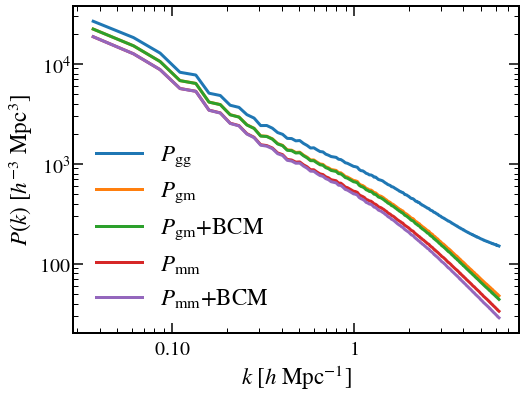

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(gpk['k'], gpk['pk'], lw=3, label=r'$P_{\rm gg}$')
ax.loglog(pgm['k'], pgm['pk'], lw=3, label=r'$P_{\rm gm}$')
ax.loglog(pgm_bcm['k'], pgm_bcm['pk'], lw=3, label=r'$P_{\rm gm}$+BCM')
ax.loglog(pmm['k'], pmm['pk'], lw=3, label=r'$P_{\rm mm}$')
ax.loglog(pmm_bcm['k'], pmm_bcm['pk'], lw=3, label=r'$P_{\rm mm}$+BCM')
ax.legend(fontsize=23)

ax.set_xlabel(r'$k \,\, [h \,\, \mathrm{Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, \mathrm{Mpc}^3]$', fontsize=23)
bacco.set_logticks(ax)

plt.show()

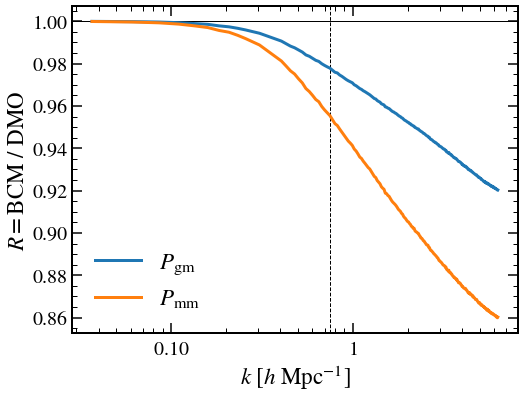

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.axhline(1, color='k', lw=1, ls='-')
ax.axvline(0.75, color='k', lw=1, ls='--')
ax.semilogx(pgm['k'], pgm_bcm['pk'] / pgm['pk'], lw=3, label=r'$P_{\rm gm}$')
ax.semilogx(pmm['k'], pmm_bcm['pk'] / pmm['pk'], lw=3, label=r'$P_{\rm mm}$')
ax.legend(fontsize=23)

ax.set_xlabel(r'$k \,\, [h \,\, \mathrm{Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$R = $BCM / DMO', fontsize=23)
bacco.set_logticks(ax, axis='x')

plt.show()